In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.stats import multivariate_normal
from numpy.linalg import norm

In [2]:
def simulator_sep(theta, z):
    return theta**2 + z**2

def simulator_full(xi):
    return np.sum(xi**2)

def gradient(xi):
    J = 2 * xi
    return (simulator_full(xi) - ystar) * J

def tangent(g):
    return svd(g.reshape(-1, 1))[0][:, 1:].flatten()

def prep_contour(xlims, ylims, step, func):
    x = np.arange(*xlims, step)
    y = np.arange(*ylims, step)
    x, y = np.meshgrid(x, y)
    xshape = x.shape
    xfl, yfl = x.flatten(), y.flatten()
    xys = np.vstack((xfl, yfl)).T
    return x, y, func(xys).reshape(xshape)

def normalize(x):
    return x / norm(x)

def tangential_covariance(lam, mu, t):
    return ((mu**2)*np.eye(2) + (lam**2 - mu**2)*np.outer(t, t.reshape(-1,1))) / np.linalg.norm(t)**2

In [3]:
ystar = 1     # Radius
eps = 0.1   # Tolerance

In [4]:
# Find initial point
random_angle = np.random.uniform(0, 2*np.pi)
theta0 = (ystar + np.random.uniform()*eps) * np.cos(random_angle)
z0 = (ystar + np.random.uniform()*eps) * np.sin(random_angle)
xi0 = np.array([theta0, z0])

In [5]:
# Current simulator value
y = simulator_full(xi0)

# Compute euclidean distance with true value
d = np.sqrt((y - ystar)**2)

# Compute gradient at the manifold corresponding to this distance
g0 = gradient(xi0)

# Compute tangent vector
t0 = tangent(g0)

In [6]:
xlim = [xi0[0]-0.5, xi0[0]+0.5]
ylim = [xi0[1]-0.5, xi0[1]+0.5]

In [7]:
# contours of the spherical MVN
spherical_sample = multivariate_normal(xi0, eps*np.eye(2)).rvs()
xxx, yyy, zzz = prep_contour(xlim, ylim, 0.01, multivariate_normal(xi0, eps*np.eye(2)).pdf)

# contours of the tangential MVN
lam = 0.5
mu = 0.1
Sigma = ((mu**2)*np.eye(2) + (lam**2 - mu**2)*np.outer(t0, t0.reshape(-1, 1))) / np.linalg.norm(t0)**2
tangential_sample = multivariate_normal(xi0, Sigma).rvs()
xxxt, yyyt, zzzt = prep_contour(xlim, ylim, 0.01, multivariate_normal(xi0, Sigma).pdf)

Should put it at 0 and work on velocities instead

In [8]:
delta = 5

In [9]:
# Travel in v direction
v = tangential_sample-xi0
xb = xi0 + delta * v
# Compute normalized gradient at xb
tbhat = normalize(gradient(xb))

In [10]:
# Reflect velocity
vr = v - 2 * (v @ tbhat) * tbhat

In [11]:
# Travel in that direction
xB = xb + delta * vr

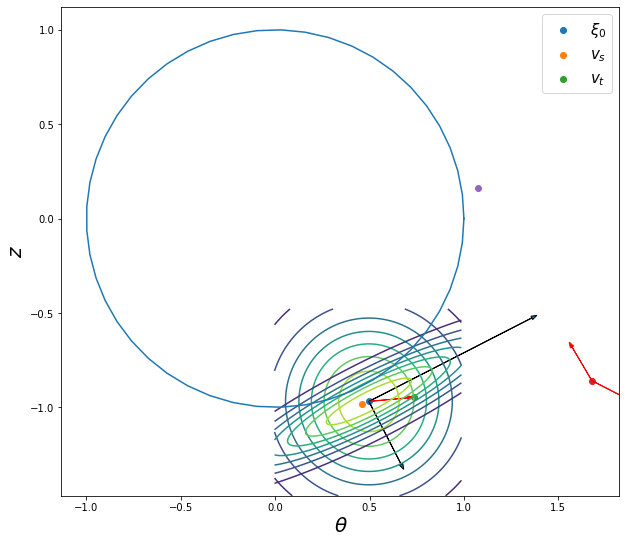

In [12]:
# Plot circle
angle = np.linspace(0, 2*np.pi)
xx = ystar * np.cos(angle)
yy = ystar * np.sin(angle)
# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(xx, yy)
ax.scatter(*xi0, label=r"$\xi_0$")
ax.arrow(*xi0, *g0, length_includes_head=True, head_width=0.02)
ax.arrow(*xi0, *t0, length_includes_head=True, head_width=0.02)
ax.scatter(*spherical_sample, label=r"$v_s$")
ax.scatter(*tangential_sample, label=r"$v_t$")
ax.contour(xxx, yyy, zzz)
ax.contour(xxxt, yyyt, zzzt)
# Arrow to tangential sample
ax.arrow(*xi0, *(tangential_sample-xi0), length_includes_head=True, head_width=0.02, color="red")
# Move in that direction
ax.scatter(*xb)
# Gradient
ax.arrow(*xb, *tbhat, length_includes_head=True, head_width=0.02, color="red")
# Reflected velocity
ax.arrow(*xb, *vr, length_includes_head=True, head_width=0.02, color="red")
# Travel in direction of reflected velocity
ax.scatter(*xB)
ax.set_xlabel(r"$\theta$", fontsize=20)
ax.set_ylabel(r"$z$", fontsize=20)
ax.set_aspect("equal")
ax.legend(fontsize=15)
plt.show()

In [13]:
spherical_sample

array([ 0.45827443, -0.98095457])

# Write a full hug algorithm

In [14]:
x = xi0
# Step size
delta = 1 / 1
# Draw tangential velocity
v0 = multivariate_normal(mean=x, cov=tangential_covariance(lam, mu, tangent(gradient(x)))).rvs()
v = v0
for b in range(1):
    # Move 
    x = x + (delta/2)*v
    # Normalized gradient
    ghat = normalize(gradient(x))
    # Reflect
    v = v - 2*(v @ ghat) * ghat
    # Move 
    x = x + (delta/2)*v

In [15]:
xi0

array([ 0.4967193 , -0.96904108])

In [16]:
v0

array([ 0.9830602 , -0.52077964])

In [17]:
def TangentialHug(x0, T, B, lam, mu, grad, tangent, logtarget):
    x = x0
    # Step size
    delta = T / B
    # Compute tangent
    t0 = tangent(grad(x))
    # Draw tangential velocity
    v0 = multivariate_normal(mean=x, cov=tangential_covariance(lam, mu, t0)).rvs()
    v = v0
    for b in range(B):
        # Move 
        x = x + (delta/2)*v
        # Normalized gradient
        ghat = normalize(grad(x))
        # Reflect
        v = v - 2*(v @ ghat) * ghat
        # Move 
        x = x + (delta/2)*v
    #logqB = multivariate_normal(mean=x, cov=tangential_covariance(lam, mu, tangent(x))).logpdf
    #logq0 = multivariate_normal(mean=x0, cov=tangential_covariance(lam, mu, t0)).logpdf
    # Log acceptance probability
    #loga = logtarget(x) - logtarget(x0) + logqB(v) - logq0(v0)
    #if np.random.rand() <= np.exp(loga):
        # accept
    #    return x, v
    #else:
        # Reject
    #    return x0, v0
    return x, v

In [155]:
TangentialHug(xi0, 1, 5, 1.0, 0.2, gradient, tangent, lambda x: 0)

(array([0.9873465 , 0.46544828]), array([-1.13376518,  0.52075136]))

In [165]:
samples = xi0
x = xi0
for _ in range(1):
    x, v = TangentialHug(x, 1, 1, 1.0, 0.2, gradient, tangent, lambda x: 0)
    samples = np.vstack((samples, x))